In [40]:
import numpy as np, matplotlib.pyplot as plt, os
from scipy.ndimage import gaussian_filter1d
from typing import Callable
from numpy.typing import NDArray

In [ ]:
# ----- CONSTANTS -----
R_MAX = 1
R_MIN = 0.1
EPS = 1e-12
NUM_BINS_SMAK = 400
SQRT_R_MAX = np.sqrt(R_MAX)
SQRT_R_MIN = np.sqrt(R_MIN)
U_MAX = 1/SQRT_R_MIN * 1.005
OUTPUT_DIR_NAME = "outputs/"

if not os.path.exists(OUTPUT_DIR_NAME):
    raise Exception("directory not found")

In [72]:
# ----- INTENSITY FUNCTIONS -----

def get_intens(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5
) -> np.ndarray[np.float64]:
    """
    Returns the brightness on the accretion disk at a given radius
    according to the inverse power law r^(-a)
    """
    return r**(-a)

def add_ring(
    base: np.ndarray,
    max_intens_frac: float,
    r: np.ndarray,
    ring_r: float,
    ring_width: float,
    beta: float = 1.5
) -> np.ndarray:
    dist_to_ring = np.abs(r - ring_r)
    not_in_ring = dist_to_ring > ring_width / 2
    max_ring = max_intens_frac * np.max(base) # max brightness value of the ring
    k = max_ring * (ring_width / 2) ** beta
    spot = np.full_like(r, max_ring)
    np.putmask(spot, not_in_ring, k * dist_to_ring ** (-beta))
    ans = np.maximum(base, spot)
    return ans

def inv_power_1_ring(
    r: np.ndarray[np.float64], 
    theta: np.ndarray[np.float64],
    a: float = 1.5,
    othher_intens_params: list[float] = [
        0.9,            # ring_max
        0.3,            # ring_r
        0.1,            # ring_width
        1.5             # beta
    ]
) -> np.ndarray[np.float64]:
    """
    `other_intens_params`: `ring_max`, `ring_r`, `ring_width`, `beta` 
    """
    (
        ring_max,
        ring_r,
        ring_width,
        beta
    ) = tuple(othher_intens_params)

    base = r**(-a)
    return add_ring(base, ring_max, r, ring_r, ring_width, beta)

def add_spot(
    base: np.ndarray,
    max_intens_frac: float,
    r: np.ndarray,
    theta: np.ndarray,
    spot_r_cent: float,
    spot_theta: float,
    spot_rad: float,
    beta: float = 1.5
) -> np.ndarray:
    dist_to_spot_cent = np.sqrt(spot_r_cent**2 + r**2 - 2 * spot_r_cent * r * np.cos(theta - spot_theta))
    not_in_spot = dist_to_spot_cent > spot_rad
    max_spot = max_intens_frac * np.max(base)
    k = max_spot * (spot_rad ** beta)
    spot = np.full_like(r, max_spot)
    np.putmask(spot, not_in_spot, k * dist_to_spot_cent ** (-beta))
    ans = np.maximum(base, spot)
    return ans

def inv_power_2_spots(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5,
        othher_intens_params: list[float] = [
            0.5,            # spot_1_max
            0.9,            # spot_r_cent_1
            -3 * np.pi/8,   # spot_theta_1
            0.04,           # spot_rad_1
            0.5,            # beta_1
            0.95,           # spot_2_max
            0.3,            # spot_r_cent_2
            5 * np.pi/8,    # spot_theta_2
            0.02,           # spot_rad_2
            1.5             # beta_2
        ]
) -> np.ndarray[np.float64]:
    """
    `other_intens_params`: `spot_1_max`, `spot_r_cent_1`,
    `spot_theta_1`, `spot_rad_1`, `beta_1`, `spot_2_max`,
    `spot_r_cent_2`, `spot_theta_2`, `spot_rad_2`, `beta_2`
    """
    (
        spot_1_max,
        spot_r_cent_1,
        spot_theta_1,
        spot_rad_1,
        beta_1,
        spot_2_max,
        spot_r_cent_2,
        spot_theta_2,
        spot_rad_2,
        beta_2
    ) = tuple(othher_intens_params)

    base = r**(-a)
    
    return add_spot(
        add_spot(
            base, spot_1_max, r, theta, spot_r_cent_1,
            spot_theta_1, spot_rad_1, beta_1
        ), spot_2_max, r, theta, spot_r_cent_2,
        spot_theta_2, spot_rad_2, beta_2
    )

def inv_power_ring_2_spots(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5,
        othher_intens_params: list[float] = [
            0.9,            # ring_max
            0.3,            # ring_r
            0.1,            # ring_width
            1.5,            # ring_beta
            0.5,            # spot_1_max
            0.9,            # spot_r_cent_1
            -3 * np.pi/8,   # spot_theta_1
            0.04,           # spot_rad_1
            0.5,            # beta_1
            0.95,           # spot_2_max
            0.3,            # spot_r_cent_2
            5 * np.pi/8,    # spot_theta_2
            0.02,           # spot_rad_2
            1.5             # beta_2
        ]
) -> np.ndarray[np.float64]:
    """
    `other_intens_params`: `ring_max`, `ring_r`, `ring_width`,
    `ring_beta`, `spot_1_max`, `spot_r_cent_1`, `spot_theta_1`,
    `spot_rad_1`, `beta_1`, `spot_2_max`, `spot_r_cent_2`,
    `spot_theta_2`, `spot_rad_2`, `beta_2`
    """
    (
        ring_max,
        ring_r,
        ring_width,
        ring_beta,
        spot_1_max,
        spot_r_cent_1,
        spot_theta_1,
        spot_rad_1,
        beta_1,
        spot_2_max,
        spot_r_cent_2,
        spot_theta_2,
        spot_rad_2,
        beta_2
    ) = tuple(othher_intens_params)

    base = r**(-a)
    
    return add_ring(
        add_spot(
            add_spot(
                base, spot_1_max, r, theta, spot_r_cent_1,
                spot_theta_1, spot_rad_1, beta_1
            ), spot_2_max, r, theta, spot_r_cent_2,
            spot_theta_2, spot_rad_2, beta_2
        ), ring_max, r, ring_r, ring_width, ring_beta
    )


# ----- PLOTTING FUNCTIONS -----

def get_grids(
    intens_func: Callable[[float, float, float], float] = get_intens,   # function(r, theta, a)
    a: float = 1.5,
    num_radial: int = 400,
    num_theta: int = 8192,
    radial_spacing: str = "log",   # "log" or "linear"
    other_intens_params: list | None = None
):
    """
    Returns a tuple of ndarrays: `(r_grid, theta_grid, intens_grid, vel_grid, area_flux_grid)`
    by sampling the disk in polar coordinates and multiplying the intensities by the area of
    each coordinate.
    """
    # --- radial edges & centres ---
    if radial_spacing == "log":
        r_edges = np.geomspace(R_MIN, R_MAX, num_radial + 1)    # num_radial points spaced logarithmically from R_MIN - R_MAX
        r_centres = get_bin_centres(r_edges, is_log=True)
    elif radial_spacing == "linear":
        r_edges = np.linspace(R_MIN, R_MAX, num_radial + 1)     # num_radial points spaced linearly from R_MIN - R_MAX
        r_centres = get_bin_centres(r_edges)
    else:
        raise Exception("invalid radial_spacing argument")
    # array of distances between r_edges of length num_radial
    dr = r_edges[1:] - r_edges[:-1]

    # theta edges & centres
    theta_edges = np.linspace(0.0, 2.0 * np.pi, num_theta + 1)
    theta_centres = get_bin_centres(theta_edges)
    dtheta = theta_edges[1] - theta_edges[0] # all equally spaced so 1st - 0th = scalar is fine

    # create 2D grid (theta x r)
    r_grid, theta_grid = np.meshgrid(r_centres, theta_centres)

    # area weight for each cell: r * dr * dtheta (from Jacobian)
    area_weights = r_grid * dr * dtheta

    # evaluate intensity and velocity on the grid
    if other_intens_params is None:
        intens_grid = intens_func(r_grid, theta_grid, a)
    else:
        intens_grid = intens_func(r_grid, theta_grid, a, other_intens_params)
    area_flux_grid = intens_grid * area_weights
    vel_grid = np.cos(theta_grid) / np.sqrt(r_grid)

    return (r_grid, theta_grid, intens_grid, vel_grid, area_flux_grid)

def plot_polar_profile(
    r_grid: np.ndarray[np.float64],
    theta_grid: np.ndarray[np.float64],
    values: np.ndarray[np.float64],
    num_contours: int = 50,
    colourmap: str = "inferno",
    title: str = "Light Flux Profile",
    colour_bar_name: str = "Value",
    figure_size: tuple[int, int] = (6, 6),
    vmin: float = None, vmax: float = None,
    colour_contrast_style: str = "90",
        # "symmetric" to set symmetric color limits around 0 (for signed fields)
        # "nonneg" to force vmin=0 and vmax=max (for non-negative fields)
    save_info: bool = False,
    fname: str | None = None
) -> None:
    """
    Plots a 2D numpy array of polar values (r, theta) on a disk with a colour bar.
    """
    # Auto colour scaling helpers
    if colour_contrast_style == "symmetric":    # colour bar ranges from - max val to + max val 
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto
        vmax_plot =  vmax_auto
    elif colour_contrast_style == "nonneg":     # colour bar ranges from 0 to max val
        vmin_plot = 0.0
        vmax_plot = np.nanmax(values)
    elif colour_contrast_style == "90":         # colour bar ranges from 10th percentile to 90th percentile
        vmin_plot = np.percentile(values, 5)
        vmax_plot = np.percentile(values, 95)
    elif (
        colour_contrast_style == "custom" and   # colour bar ranges from vmin to vmax
        vmin is not None and vmax is not None
    ):
        vmin_plot = vmin
        vmax_plot = vmax
    else:
        raise Exception("invalid colour contrast arguments")


    fig, ax = plt.subplots(figsize=figure_size, subplot_kw=dict(projection="polar"))
    contour = ax.contourf(
        theta_grid, r_grid, values,
        levels=num_contours,
        vmin=vmin_plot, #TODO: fix this
        vmax=vmax_plot,
        cmap=colourmap
    )
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label(colour_bar_name)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if save_info:
        if fname is None:
            raise Exception("invalid intens_func_name")
        if fname.endswith(".png"):
            plt.savefig(OUTPUT_DIR_NAME + fname)
            # print(f"saved profile to {OUTPUT_DIR_NAME + fname}")
        else:
            plt.savefig(OUTPUT_DIR_NAME + fname + ".png")
            # print(f"saved profile to {OUTPUT_DIR_NAME + fname} + .png")
    plt.show()


def get_hist_vals(
    vel_grid: np.ndarray[np.float64],
    area_flux_grid: np.ndarray[np.float64], *,
    num_bins: int = 1200,
    normalise: bool = True,
    smooth_sigma: float | None = None
) -> tuple[np.ndarray[np.float64], np.ndarray[np.float64]]:
    """
    Flattens and places valid `area_flux_grid` values into `num_bins` bins
    using numpy\'s `histogram` function. Returns the tuple
    `(u_bin_centres, hist_brightness_vals)`.
    """
    u_flat = vel_grid.ravel()
    a_flux_flat = area_flux_grid.ravel()

    # remove NaNs/Infs and (unnecessary) zero-weight samples
    finite_mask = np.isfinite(u_flat) & np.isfinite(a_flux_flat) & (a_flux_flat > 0)
    u_flat = u_flat[finite_mask]
    a_flux_flat = a_flux_flat[finite_mask]

    # --- histogram into uniform velocity bins that scale with R_MIN ---
    u_bin_edges = np.linspace(-U_MAX, U_MAX, num_bins + 1)
    hist_brightness_vals, _ = np.histogram(u_flat, bins=u_bin_edges, weights=a_flux_flat) #returns bin edges as well but that's not needed
    u_bin_centres = get_bin_centres(u_bin_edges)

    if normalise and np.max(hist_brightness_vals) > 0:
        hist_brightness_vals /= np.max(hist_brightness_vals)

    if smooth_sigma is not None and smooth_sigma > 0:
        hist_brightness_vals = gaussian_filter1d(hist_brightness_vals, sigma=smooth_sigma)

    return u_bin_centres, hist_brightness_vals

def plot_spectrum_list(
    a_vals: (
        np.ndarray[np.float64] | float
    ) = np.arange(0, 2.51, 0.5),
    intens_funcs: (
        list[Callable[[float, float, float], float]] | 
        Callable[[float, float, float], float]
    ) = get_intens,
    other_intens_params: list | None = None,
    plot_smak: bool = False,
    sigma: float = None, *,
    xlim: tuple[float, float] = (-5, 5),
    xlabel="Doppler shift",
    ylabel="Light Flux",
    title="Light Spectrum",
    figure_size: tuple[float, float] = (8, 5),
    grid_alpha: float = 0.3,
    save_info: bool = False
) -> str | None:
    """
    Plots the model intensity over a range of u values (speeds/wavelengths) for a disk with
    brightness decsribed by the functions in `intens_funcs` over a range of `a_vals`. Optionally
    plots Smak analytical solitions on top if `plot_smak` is `True`.
    """
#region Exception handling
    if sigma is not None and sigma <= 0:
        raise Exception("Invalid sigma argument")
    if a_vals is None:
        raise Exception("Invalid a_vals argument")
    if intens_funcs is None:
        raise Exception("Invalid intens_funcs argument")

    only_one_a = False
    if isinstance(a_vals, (int, float)):
        only_one_a = True
    elif not isinstance(a_vals, np.ndarray) or len(a_vals) == 0:
        raise Exception("Invalid a_vals argument")
    
    only_one_func = False
    if isinstance(intens_funcs, Callable):
        only_one_func = True
    elif not isinstance(intens_funcs, list) or len(intens_funcs) == 0:
        raise Exception("Invalid only_one_func argument")
    
    num_options = 1
    if only_one_a:
        if not only_one_func:
            num_options = len(intens_funcs)
        a_vals = np.array([a_vals] * num_options)
    if only_one_func:
        if not only_one_a:
            num_options = len(a_vals)
        intens_funcs = [intens_funcs] * num_options

    if len(a_vals) != len(intens_funcs):
        raise Exception("only_one_func should have same length as a_vals")
#endregion

    plt.figure(figsize=figure_size)

    for i in range(len(a_vals)):
        cur_a = a_vals[i]
        cur_func = intens_funcs[i]
        # radial sampling
        _, _, _, vel_grid, area_flux_grid = get_grids(
            intens_func=cur_func, a=cur_a,
            other_intens_params=other_intens_params
        )
        u_bin_centres, hist_brightness_vals = get_hist_vals(vel_grid, area_flux_grid)


        if sigma is not None:
            hist_brightness_vals = gaussian_filter1d(hist_brightness_vals, sigma=sigma)

        model_label = f"a = {cur_a}" #, func_ID = {i}"

        if plot_smak:
            smak_u_vals = np.linspace(-U_MAX, U_MAX, NUM_BINS_SMAK)
            smak_brightness = smak_F(smak_u_vals, cur_a)
            if sigma is not None:
                smak_brightness = gaussian_filter1d(smak_brightness, sigma=sigma)
            
            model_label = f"Model (a={cur_a})"
            smak_label = f"Smak (a={cur_a})"

            plt.plot(
                smak_u_vals, smak_brightness,
                linestyle = "--", label=smak_label
            )

        plt.plot(
            u_bin_centres, hist_brightness_vals,
            linestyle = '-', label = model_label
        )

    plt.xlabel(f"{xlabel}")
    plt.ylabel(ylabel)
    if len(a_vals) > 1:
        plt.legend()
        a_tag = ""
    else:
        a_tag = f" (a = {a_vals[0]})"
    smooth_tag = f" (Gaussian smoothed, sigma={sigma:g})" if (sigma is not None and sigma > 0) else ""
    plt.title(title + smooth_tag + a_tag)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.tight_layout()
    if save_info:
        gen_fname = OUTPUT_DIR_NAME
        for i in range(len(a_vals)):
            gen_fname += intens_funcs[i].__name__ + f"_a_{a_vals[i]:.2f}__"
        if sigma is not None:
            gen_fname += f"sigma_{sigma:.1f}__"
            print(gen_fname)
        else:
            gen_fname += "sigma_None__"
        if other_intens_params is not None:
            for param in other_intens_params:
                gen_fname += f"{param:.2f}_"
        gen_fname = gen_fname.strip("_")
        plt.savefig(f"{gen_fname}_spectrum.png")
    plt.show()
    if save_info:
        return gen_fname + ".png"


# ----- SMAK FUNCTIONS -----

def smak_F(u_vals: np.ndarray[np.float64], a: float) -> np.ndarray[np.float64]:
    """
    Returns a numpy array of intensity values F(u) associated with the array
    of `u_vals` given, according to Smak\'s analytical solution.
    """
    intensities = np.full_like(u_vals, np.nan, float)   # make array of NaNs

    exp = 2*a - 5

    for j, u in enumerate(u_vals):
        # guard the singular prefactor at u=0 if exponent < 0
        if abs(u) < EPS and exp < 0:
            intensities[j] = np.nan
            continue

        x_z = np.clip(u, -1.0, 1.0)
        x_1 = np.clip(u * SQRT_R_MIN, -1.0, 1.0)

        upper = smak_I(a, x_z)
        lower = smak_I(a, x_1)
        diff  = upper - lower

        intensities[j] = (u**exp) * diff

    # normalise robustly (optional)
    finite = np.isfinite(intensities)
    norm_intens = intensities
    if finite.any(): # check if any intensities are finite
        amp = np.nanmax(np.abs(intensities))
        if (np.isfinite(amp) and amp > 0):
            norm_intens = intensities / amp

    return norm_intens

def smak_I(a: float, x: float) -> float:
    """
    Helper function for :func:`smak_F`.
    """
    result = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            result = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            result = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            result = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            result = -s
        elif a == 2.0:
            result = np.arcsin(x)
        elif a == 2.5:
            result = np.log(abs((1.0 - s) / x)) if abs(x) > EPS else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return result


# ----- HELPER FUNCTIONS -----

def get_bin_centres(edges: np.ndarray, is_log: bool = False) -> np.ndarray:
    if is_log:
        # geometric-centre for each bin in log space
        return np.sqrt(edges[:-1] * edges[1:])
    # bin centres for linearly spaced edges
    return (edges[:-1] + edges[1:]) / 2

def plot_prof_spec_prof_from_fn(
    filename: str, plot_prof: bool = True,
    plot_spec: bool = True,
    save_info: bool = False
) -> None:
    """
    Performs :func:`plot_spectrum_list`` with parameters defined by the filename.
    """
    left, right = tuple(filename.split("__sigma_"))
    intens_func_and_as = left.split("__")
    intens_funcs = []
    a_vals = []
    for cur_pair in intens_func_and_as:
        intens_func_name, a = tuple(cur_pair.split("_a_"))
        intens_func = globals()[intens_func_name]
        intens_funcs.append(intens_func)
        a_vals.append(float(a))
    sigma_others = right.split("__")
    if len(sigma_others) > 1:
        sigma, others = tuple(sigma_others)
        other_params = [float(o) for o in others.split("_")]
    else:
        sigma = sigma_others[0]
        other_params = None
    if sigma == "None":
        sigma = None
    else:
        sigma = float(sigma)
    # for func in intens_funcs:
        # print(func.__name__)
        # print(a_vals)
        # print(sigma)
        # print(other_params)
    if plot_spec:
        plot_spectrum_list(
            np.array(a_vals), intens_funcs, other_params, sigma=sigma, save_info=save_info
        )
    if plot_prof:
        for i in range(len(intens_funcs)):
            r_vals, theta_vals, intens_vals, _, _ = get_grids(
                intens_func=intens_funcs[i], a=a_vals[i],
                other_intens_params=other_params
            )
            plot_polar_profile(
                r_vals, theta_vals, intens_vals,
                title=f"Light Flux Profile (a = {a_vals[i]})",
                save_info=save_info, fname=file_name
            )
            print(f"saved profile to {file_name}")

outputs/auto_generated/get_intens_a_0.00__get_intens_a_2.00__get_intens_a_3.00__get_intens_a_4.00__get_intens_a_12.00__sigma_2.0__


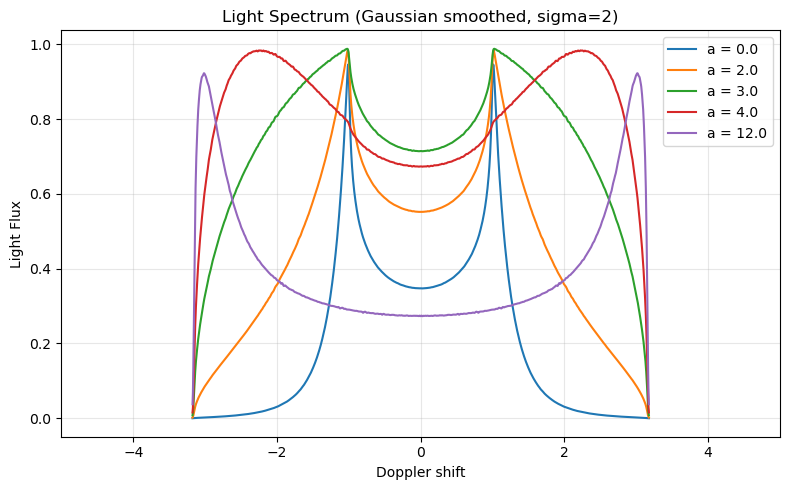

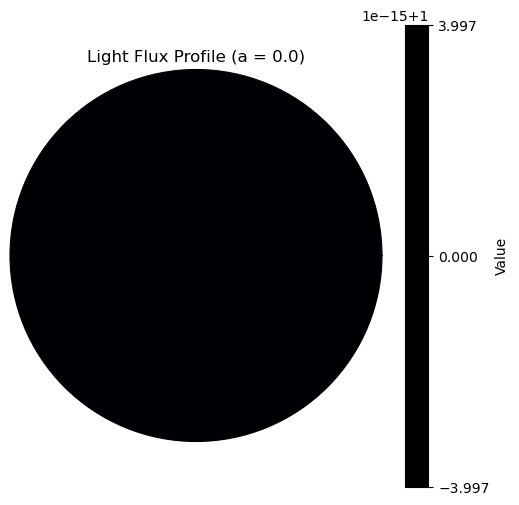

saved profile to get_intens_a_0.00__get_intens_a_2.00__get_intens_a_3.00__get_intens_a_4.00__get_intens_a_12.00__sigma_2.0


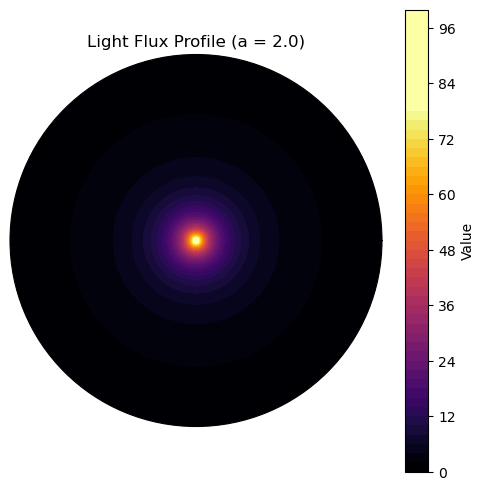

saved profile to get_intens_a_0.00__get_intens_a_2.00__get_intens_a_3.00__get_intens_a_4.00__get_intens_a_12.00__sigma_2.0


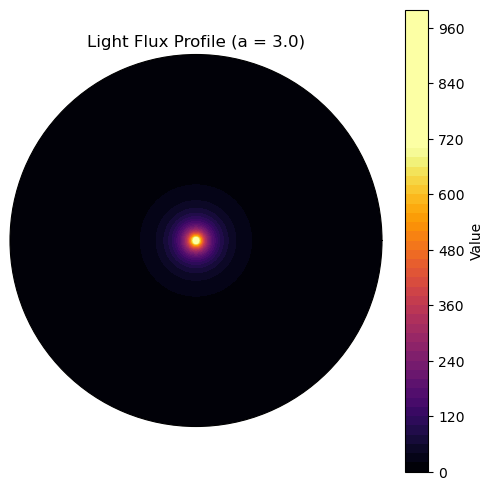

saved profile to get_intens_a_0.00__get_intens_a_2.00__get_intens_a_3.00__get_intens_a_4.00__get_intens_a_12.00__sigma_2.0


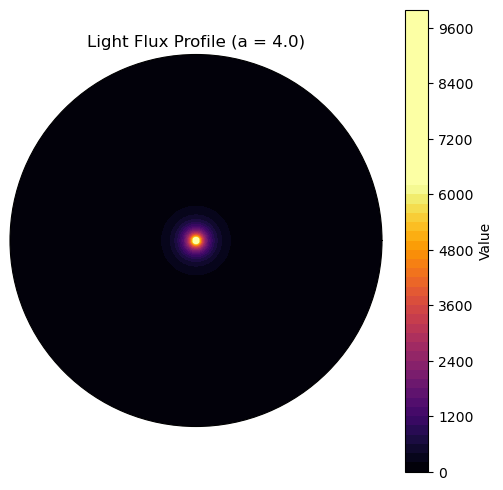

saved profile to get_intens_a_0.00__get_intens_a_2.00__get_intens_a_3.00__get_intens_a_4.00__get_intens_a_12.00__sigma_2.0


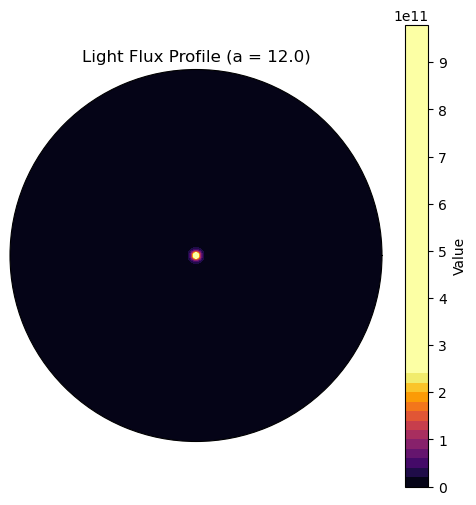

saved profile to get_intens_a_0.00__get_intens_a_2.00__get_intens_a_3.00__get_intens_a_4.00__get_intens_a_12.00__sigma_2.0
outputs/auto_generated/inv_power_2_spots_a_1.00__sigma_2.0__


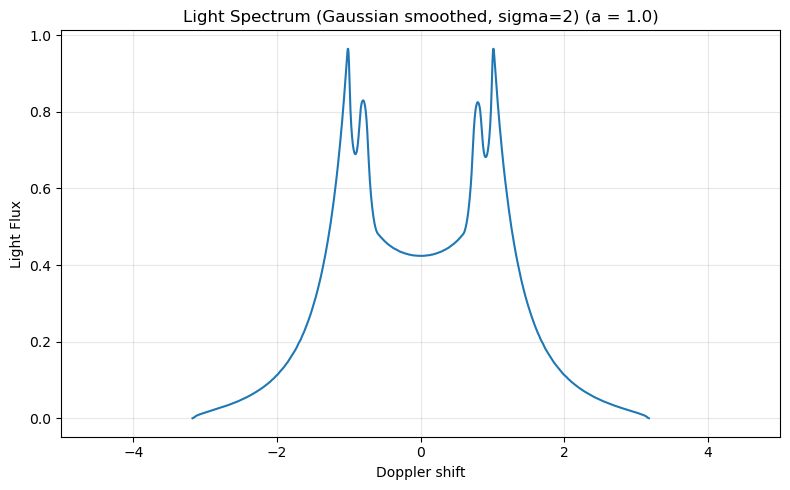

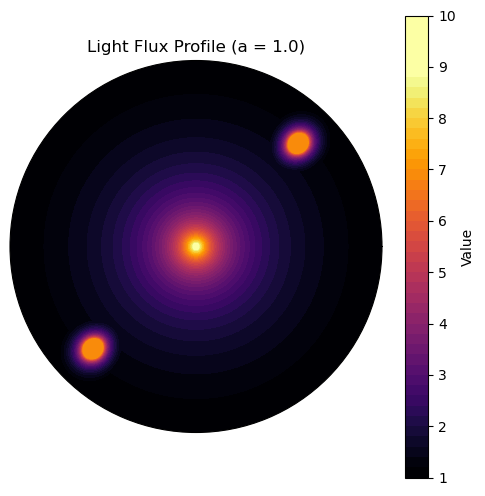

saved profile to inv_power_2_spots_a_1.00__sigma_2.0__0.70_0.80_0.79_0.05_1.50_0.70_0.80_-2.36_0.05_1.50


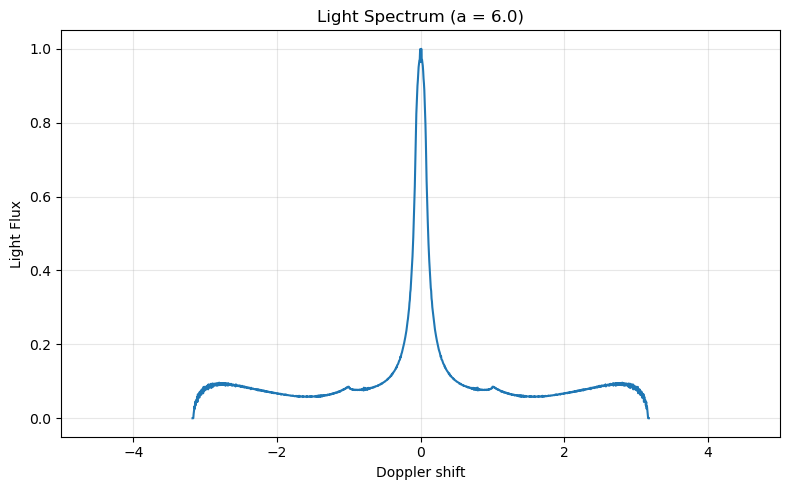

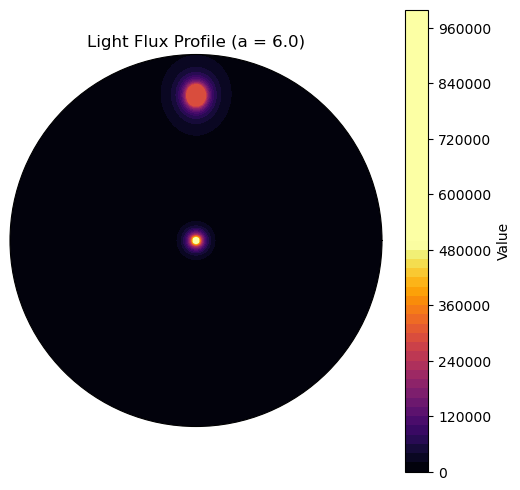

saved profile to inv_power_ring_2_spots_a_6.00__sigma_None__0.00_0.75_0.05_1.50_0.30_0.80_1.57_0.05_2.00_0.00_0.80_1.51_0.05_1.50
outputs/auto_generated/inv_power_2_spots_a_1.00__sigma_2.0__


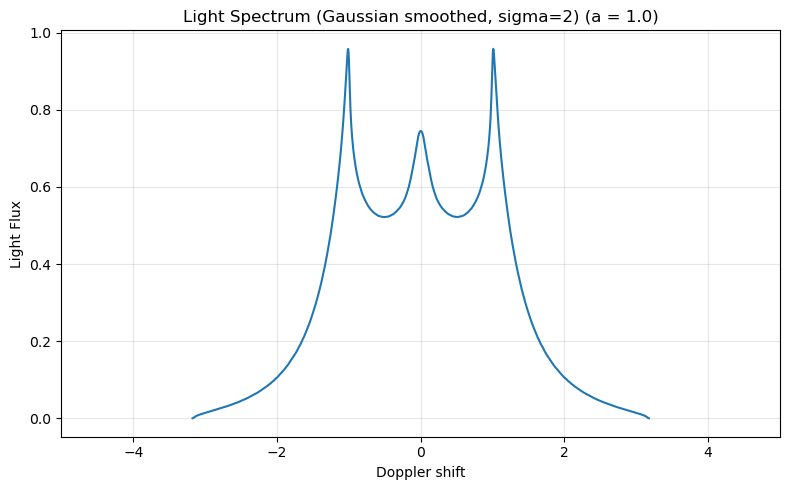

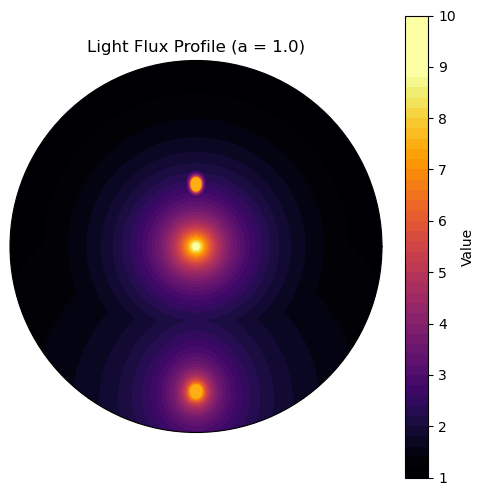

saved profile to inv_power_2_spots_a_1.00__sigma_2.0__0.75_0.40_1.57_0.03_1.50_0.75_0.80_-1.57_0.03_0.50
outputs/auto_generated/inv_power_ring_2_spots_a_16.00__sigma_2.0__


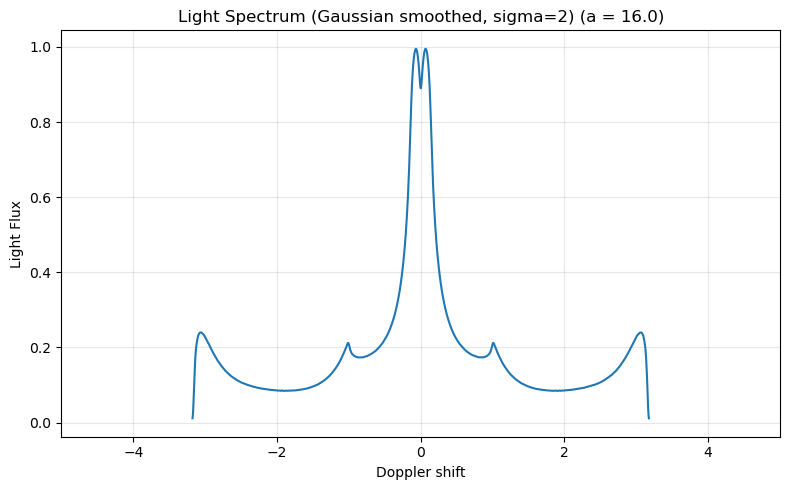

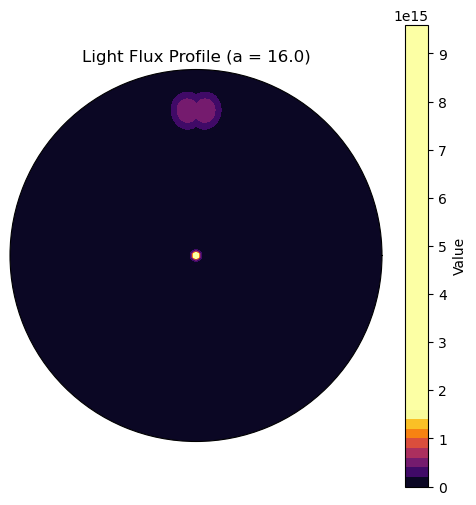

saved profile to inv_power_ring_2_spots_a_16.00__sigma_2.0__0.00_0.25_0.05_1.50_0.05_0.80_1.63_0.05_1.50_0.05_0.80_1.51_0.05_1.50
outputs/auto_generated/inv_power_2_spots_a_1.00__sigma_2.0__


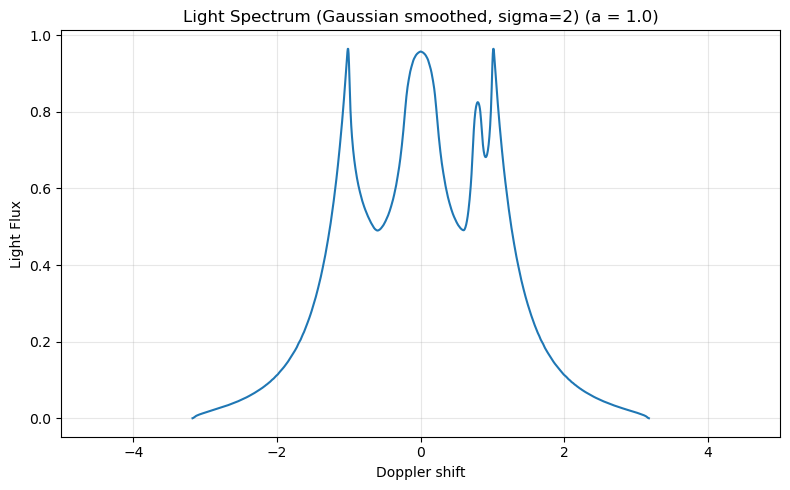

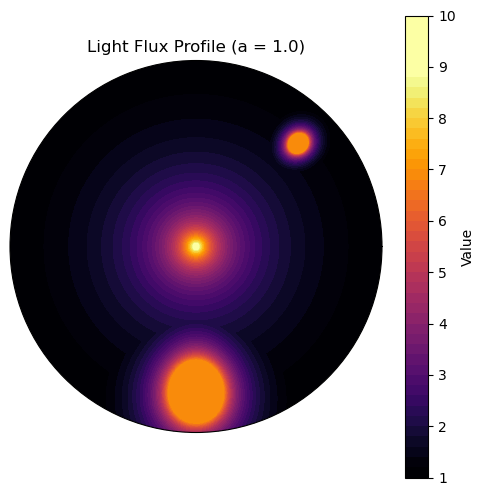

saved profile to inv_power_2_spots_a_1.00__sigma_2.0__0.70_0.80_0.79_0.05_1.50_0.70_0.80_-1.57_0.15_1.50
outputs/auto_generated/inv_power_1_ring_a_1.00__sigma_2.0__


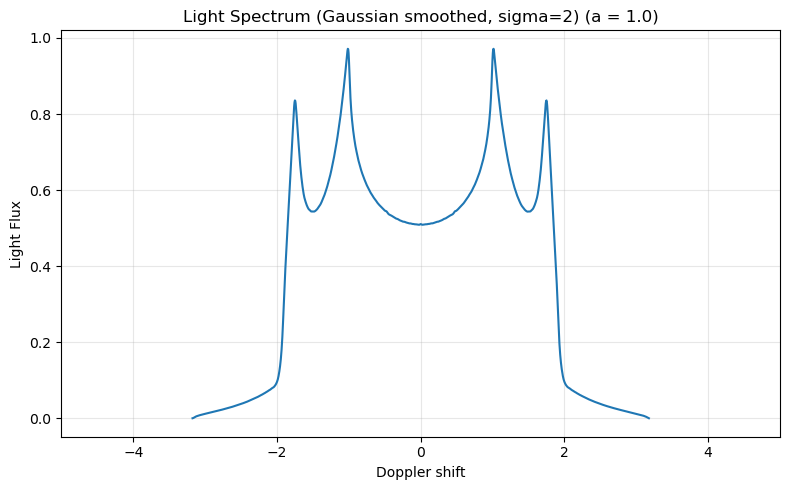

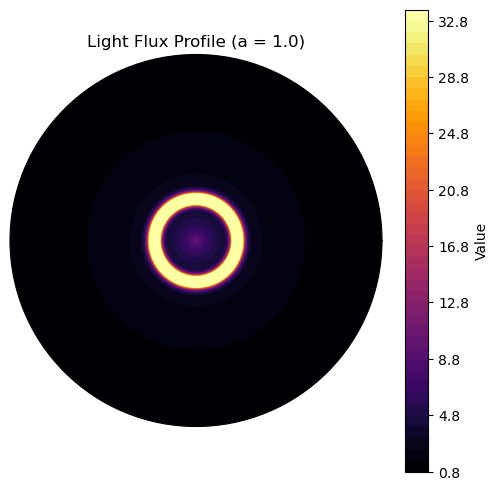

saved profile to inv_power_1_ring_a_1.00__sigma_2.0__3.30_0.30_0.05_2.50
outputs/auto_generated/inv_power_2_spots_a_1.00__sigma_2.0__


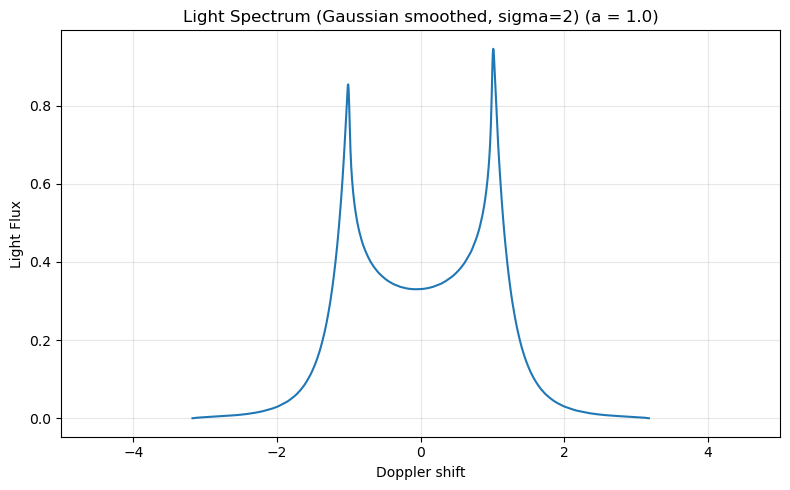

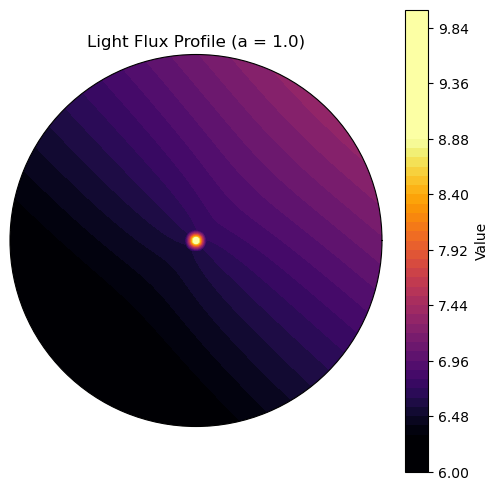

saved profile to inv_power_2_spots_a_1.00__sigma_2.0__6.00_21.00_0.79_7.00_2.00_0.00_0.80_-1.57_0.03_0.50
outputs/auto_generated/inv_power_2_spots_a_1.00__sigma_2.0__


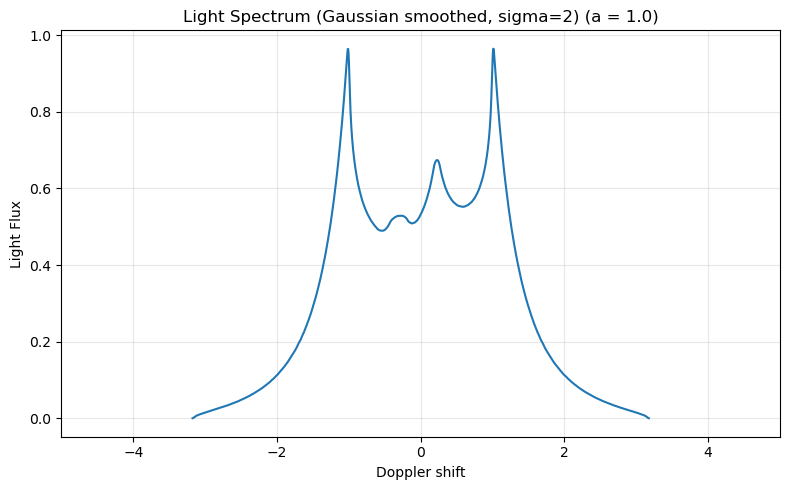

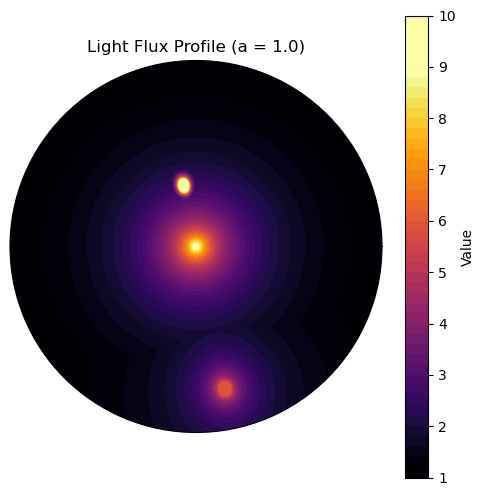

saved profile to inv_power_2_spots_a_1.00__sigma_2.0__0.95_0.40_1.77_0.03_1.50_0.60_0.80_-1.37_0.03_0.50
outputs/auto_generated/inv_power_2_spots_a_1.00__sigma_2.0__


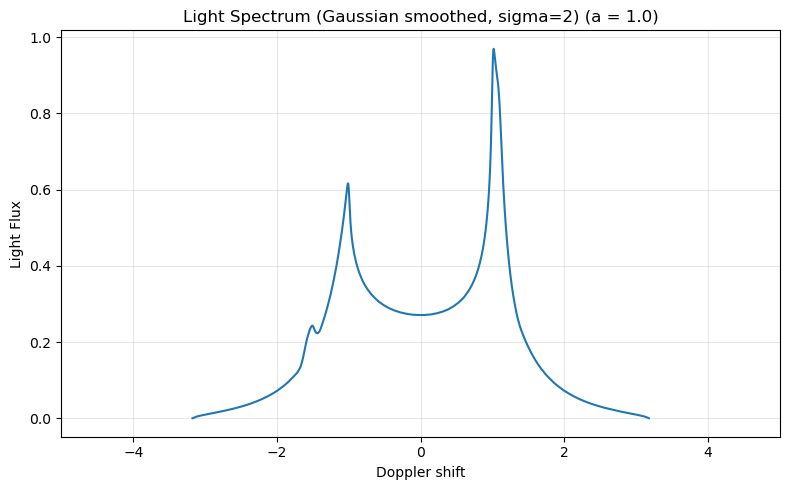

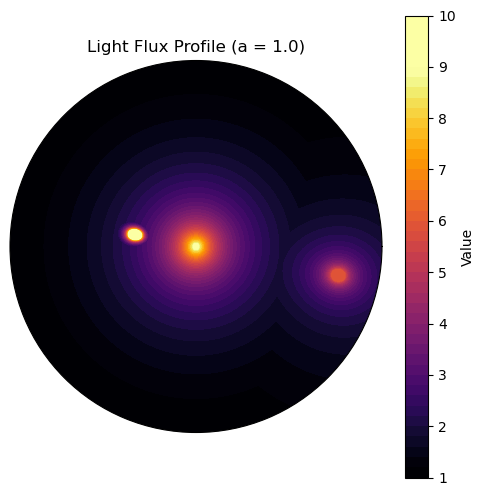

saved profile to inv_power_2_spots_a_1.00__sigma_2.0__0.95_0.40_2.95_0.03_1.50_0.60_0.80_-0.20_0.03_0.50


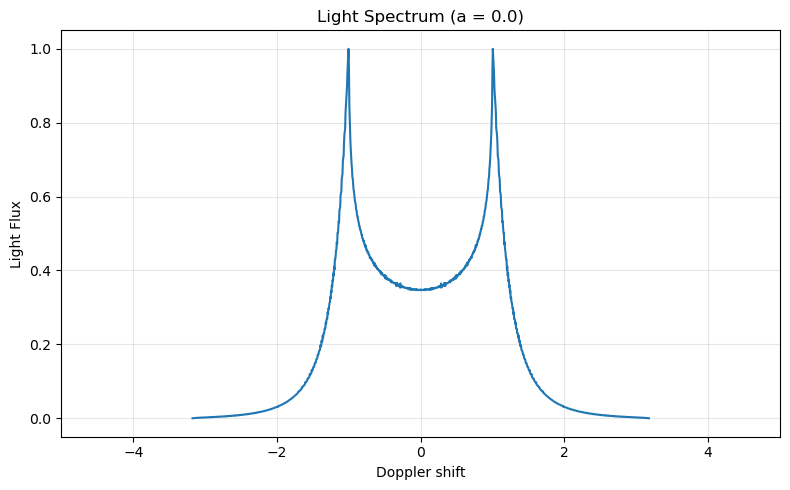

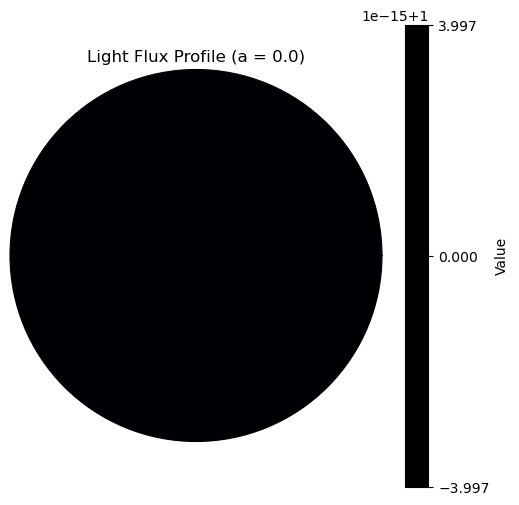

saved profile to get_intens_a_0.00__sigma_None
outputs/auto_generated/get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1.0__


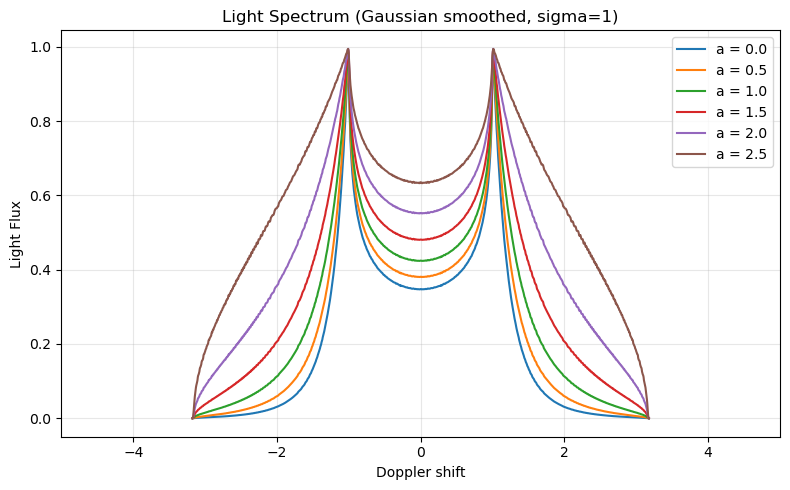

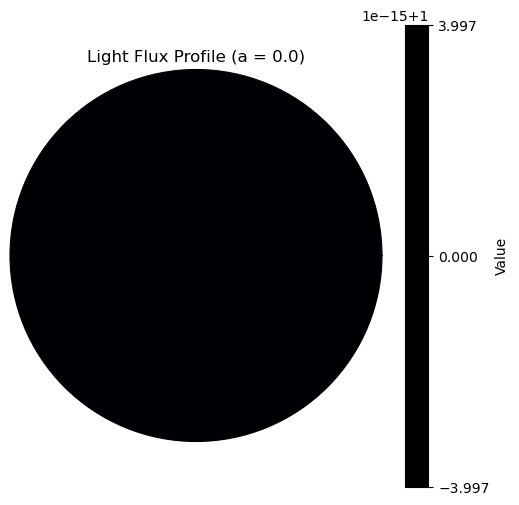

saved profile to get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1


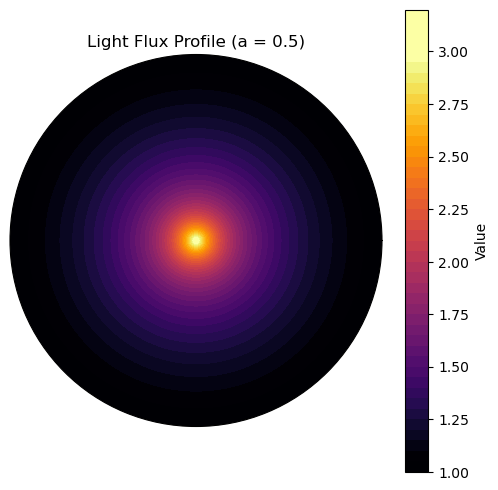

saved profile to get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1


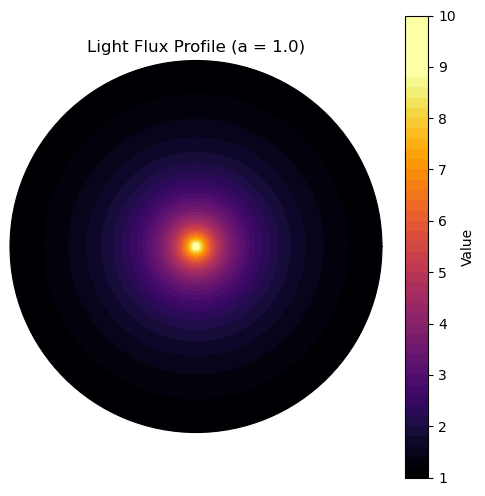

saved profile to get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1


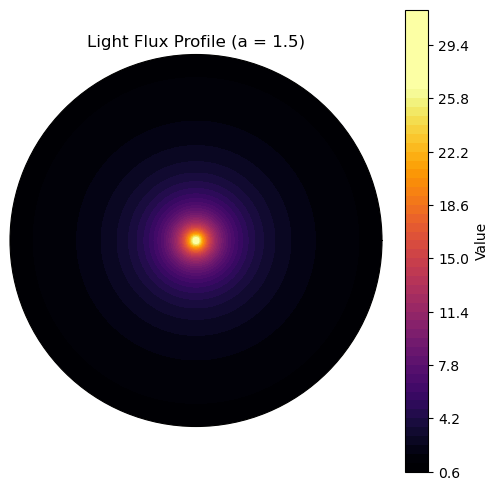

saved profile to get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1


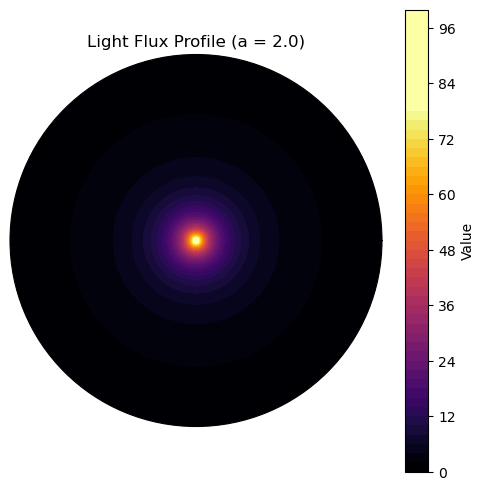

saved profile to get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1


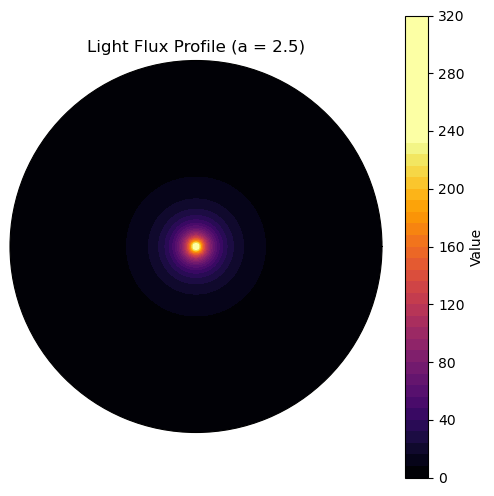

saved profile to get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1
outputs/auto_generated/inv_power_1_ring_a_1.00__sigma_2.0__


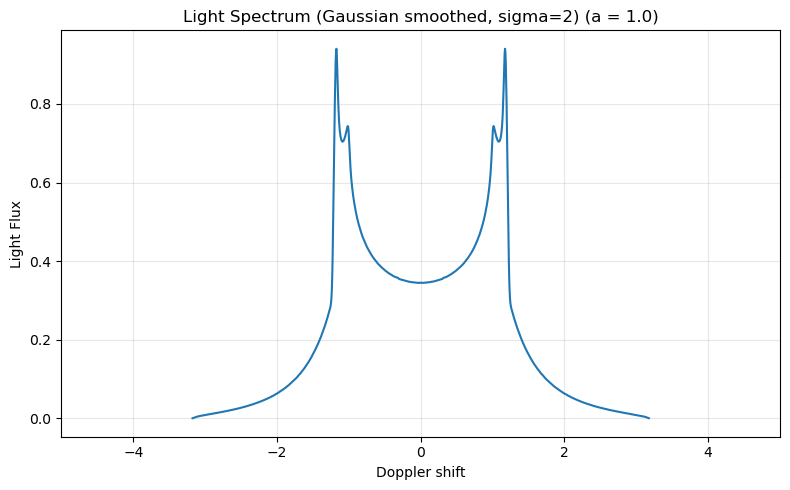

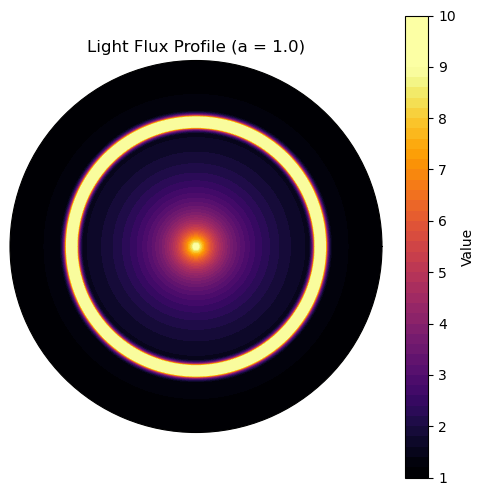

saved profile to inv_power_1_ring_a_1.00__sigma_2.0__0.90_0.70_0.05_2.50
outputs/auto_generated/inv_power_1_ring_a_1.00__sigma_2.0__


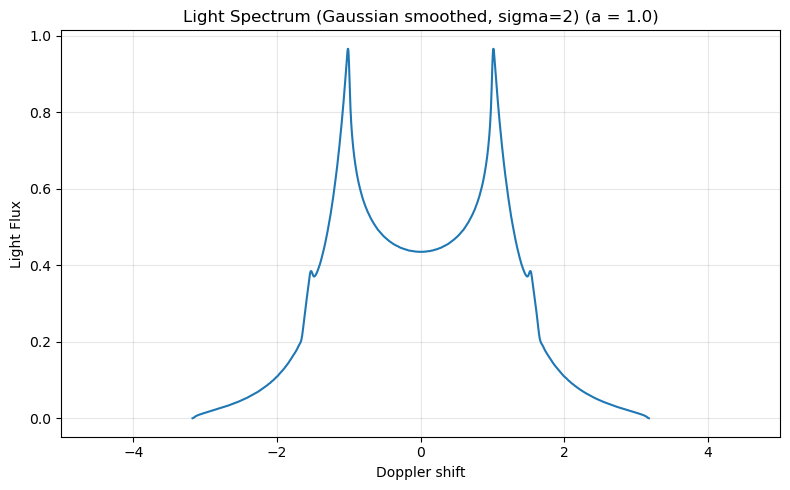

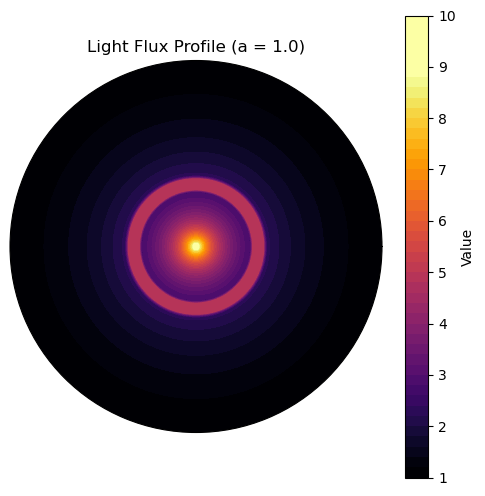

saved profile to inv_power_1_ring_a_1.00__sigma_2.0__0.50_0.40_0.05_1.50


In [ ]:
# function to retrieve a list of all file names in the outputs directory
def get_output_file_names(output_dir_name: str = OUTPUT_DIR_NAME):
    fnames = [f for f in os.listdir(output_dir_name) if os.path.isfile(os.path.join(output_dir_name, f))]
    return set(
        [name[:-4] for name in fnames if "_spectrum" not in name] +
        [name[:-13] for name in fnames if "_spectrum" in name]
    )

for file_name in get_output_file_names(OUTPUT_DIR_NAME + "not_auto_generated/"):
    # print(file_name)
    plot_prof_spec_prof_from_fn(file_name, save_info=True)


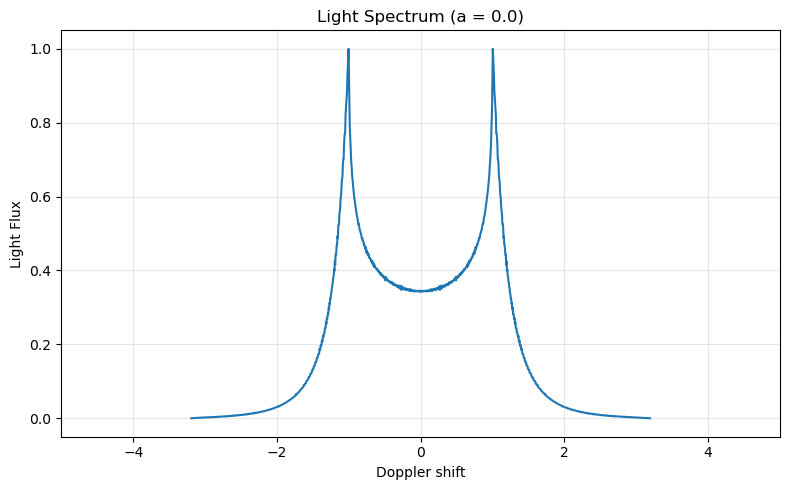

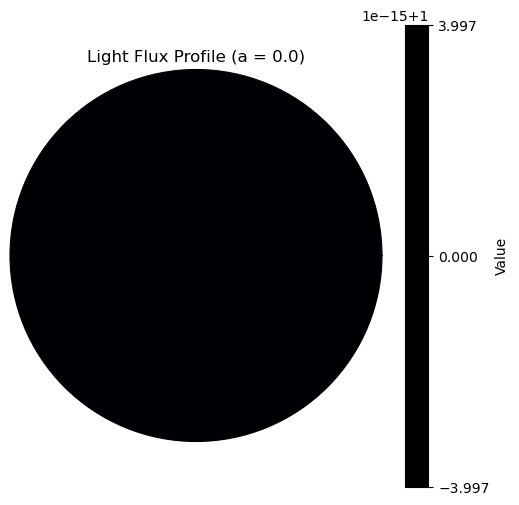

In [ ]:
plot_prof_spec_prof_from_fn("get_intens_a_0.00__sigma_None")

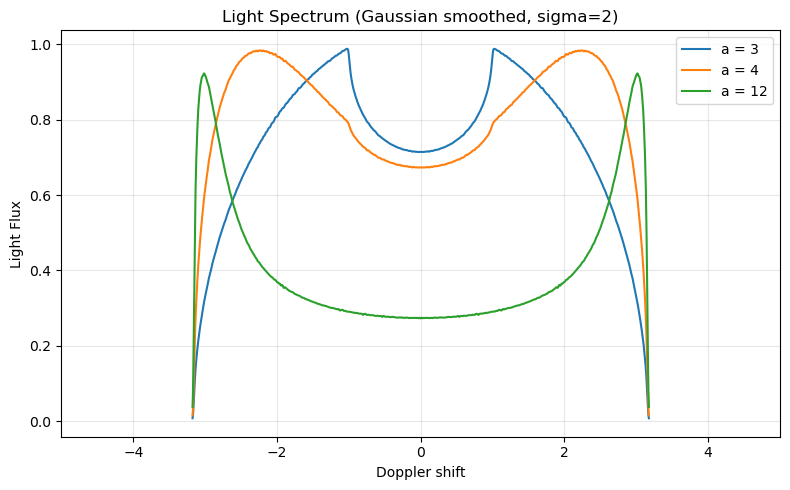

In [ ]:
plot_spectrum_list(np.array([3, 4, 12]), get_intens, sigma=2, save_info=False)

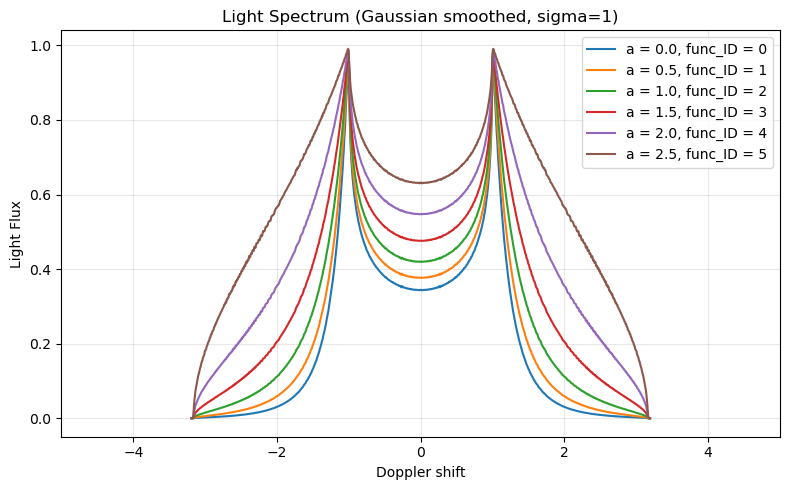

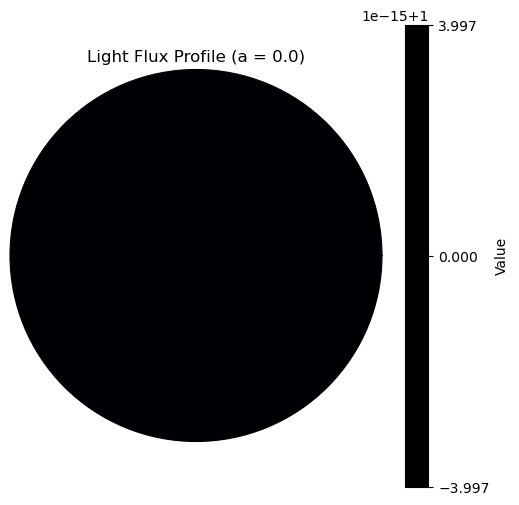

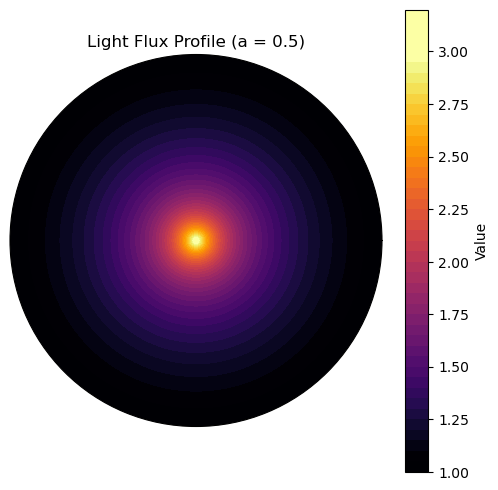

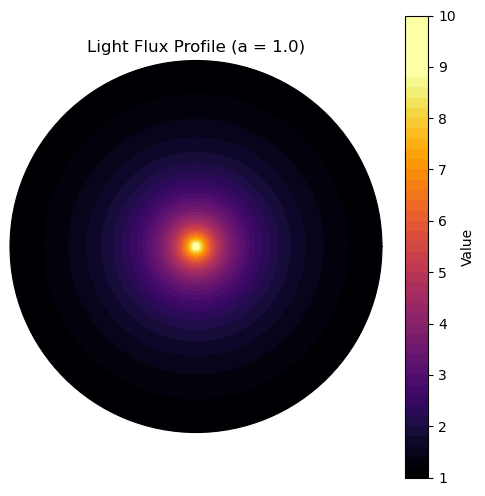

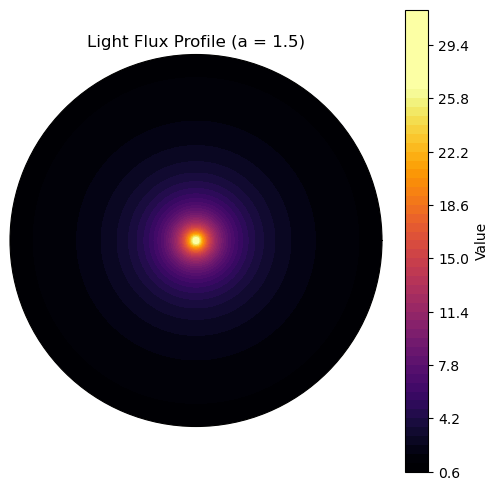

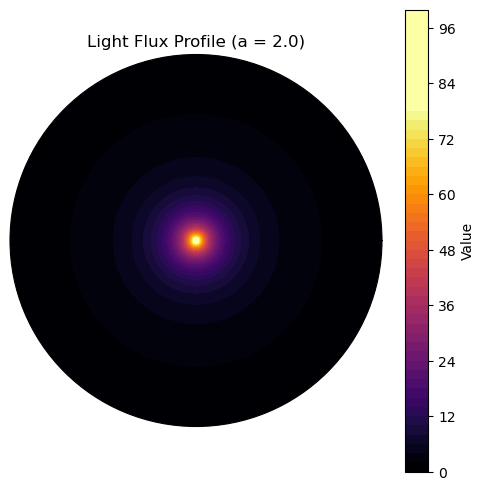

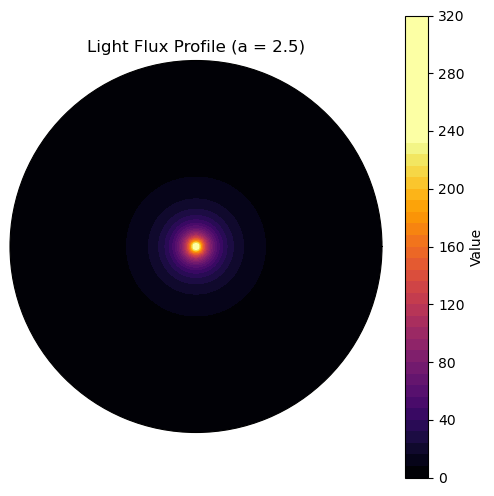

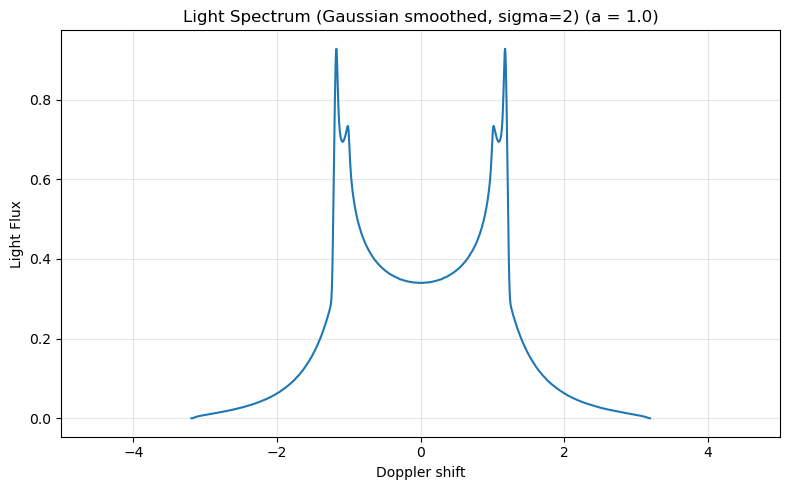

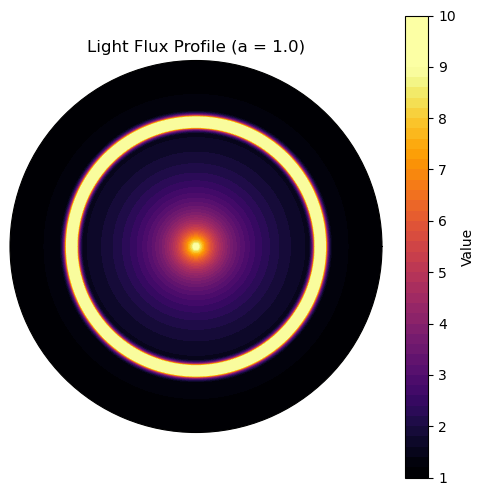

In [ ]:
plot_prof_spec_prof_from_fn("get_intens_a_0.00__get_intens_a_0.50__get_intens_a_1.00__get_intens_a_1.50__get_intens_a_2.00__get_intens_a_2.50__sigma_1")
plot_prof_spec_prof_from_fn("inv_power_1_ring_a_1.00__sigma_2__0.90_0.70_0.05_2.50")

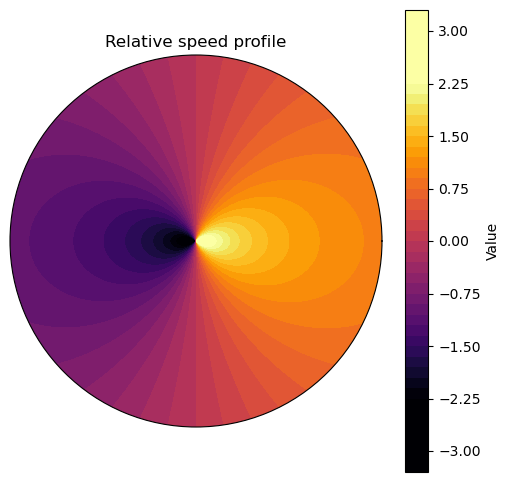

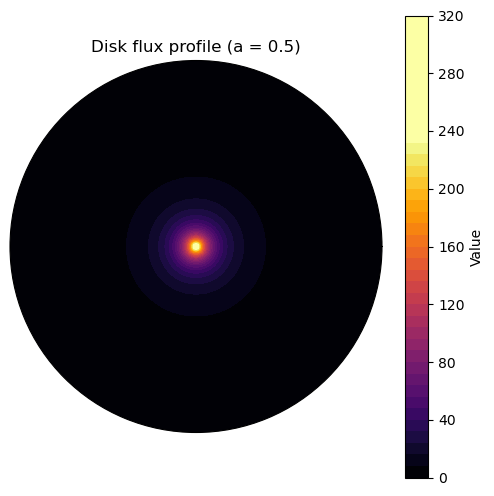

In [ ]:
# ----- TESTING -----

r_vals, theta_vals, intens_vals, vel_vals, area_flux_vals = get_grids(a=2.5)


plot_polar_profile(r_vals, theta_vals, vel_vals, title="Relative speed profile")
plot_polar_profile(r_vals, theta_vals, intens_vals, title="Disk flux profile (a = 0.5)")

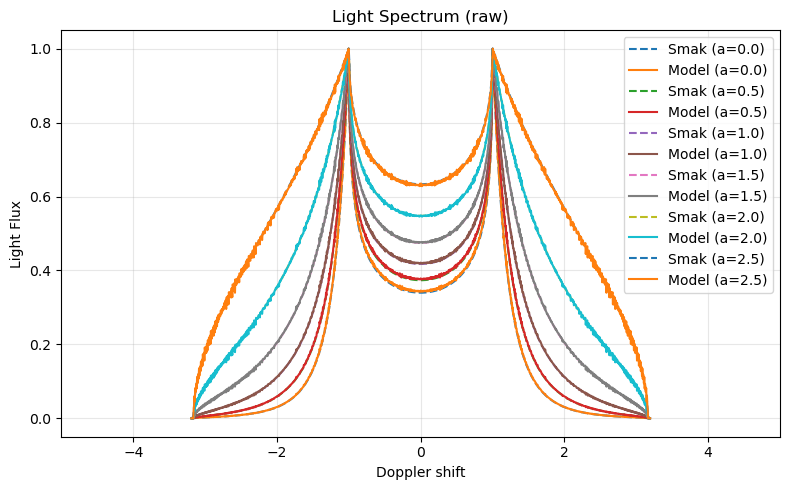

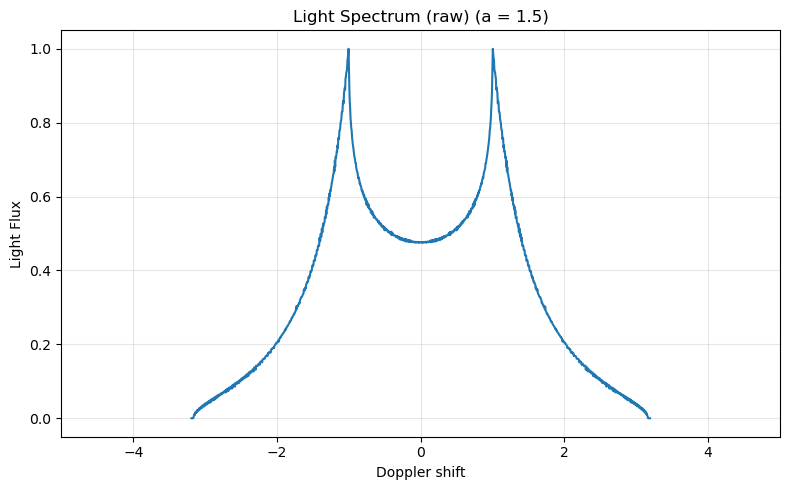

In [ ]:
# ----- TESTING -----

sigma = None
plot_smak = R_MAX == 1
title = "Light Spectrum"
title += " (raw)" if sigma is None else ""

plot_spectrum_list(title=title, plot_smak=plot_smak, sigma=sigma)
plot_spectrum_list(title=title, a_vals=1.5, sigma=sigma)

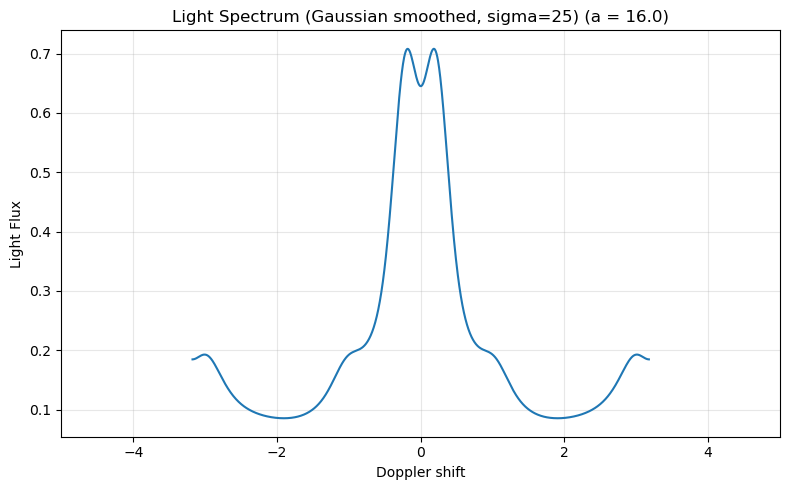

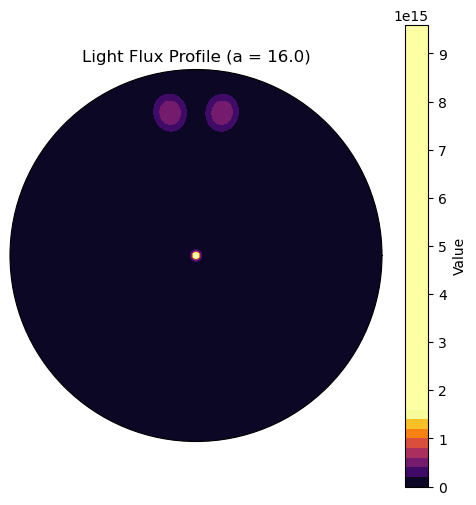

In [ ]:
plot_prof_spec_prof_from_fn("inv_power_ring_2_spots_a_16.00__sigma_25__0.00_0.25_0.05_1.50_0.05_0.80_1.75_0.05_1.50_0.05_0.80_1.39_0.05_1.50")

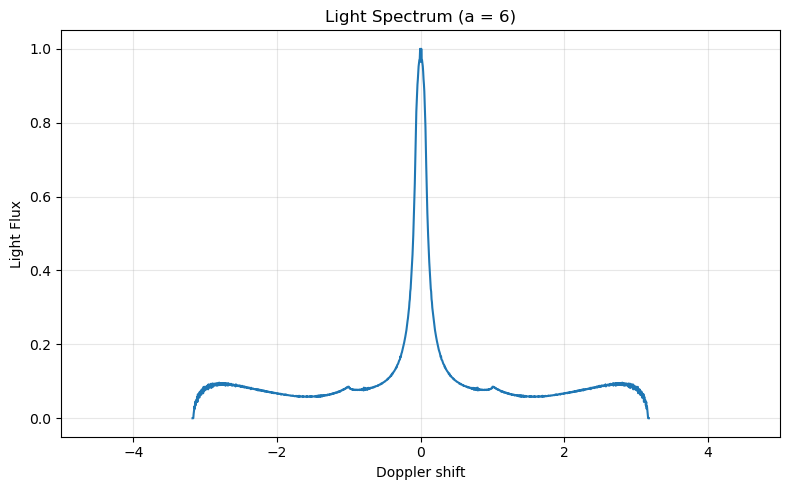

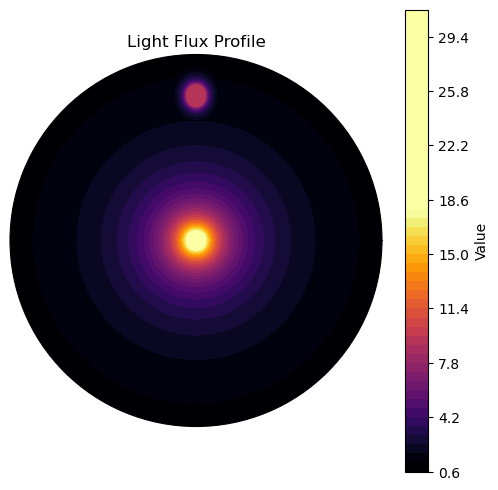

In [ ]:
other_params = [
    0.00,            # ring_max
    0.75,            # ring_r
    0.05,            # ring_width
    1.5,            # ring_beta
    0.3,           # spot_1_max
    0.8,            # spot_r_cent_1
    0.5 * np.pi,  # spot_theta_1
    0.05,           # spot_rad_1
    2,            # beta_1
    0.00,           # spot_2_max
    0.8,            # spot_r_cent_2
    0.48 * np.pi,  # spot_theta_2
    0.05,           # spot_rad_2
    1.5             # beta_2
]

r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids( #TODO: fix
    inv_power_ring_2_spots, radial_spacing="linear",
    other_intens_params= other_params
)

fname = plot_spectrum_list(
    a_vals=6, intens_funcs=inv_power_ring_2_spots,
    other_intens_params=other_params, sigma=None, save_info=True
)

plot_polar_profile(r_vals, theta_vals, intens_vals, save_info=True, fname=fname)

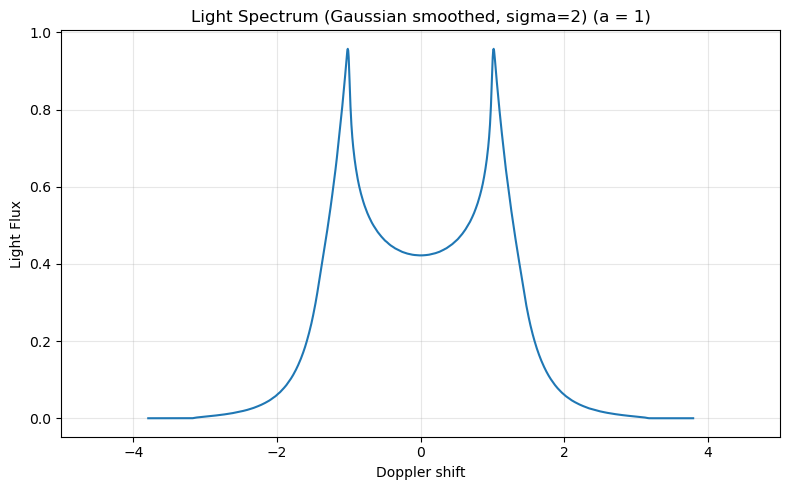

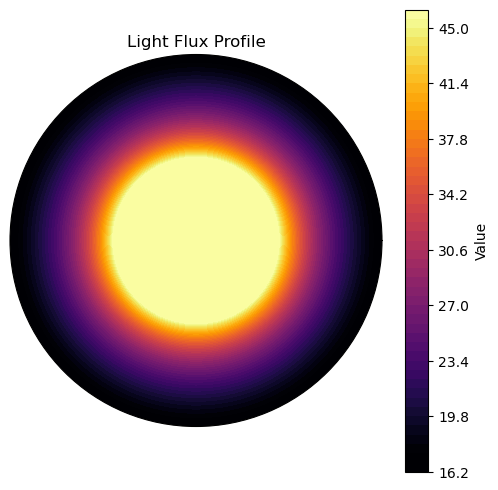

In [ ]:
spots_params = [
    1.48,           # spot_1_max
    0.0,            # spot_r_cent_1
    4 * np.pi/16,   # spot_theta_1
    0.5,           # spot_rad_1
    1.5,            # beta_1
    0.0,            # spot_2_max
    0.6,            # spot_r_cent_2
    -7 * np.pi/16,  # spot_theta_2
    0.03,           # spot_rad_2
    0.5             # beta_2
]
r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids( #TODO: fix
    inv_power_2_spots, radial_spacing="linear",
    other_intens_params= spots_params
)

fname = plot_spectrum_list(
    a_vals=1, intens_funcs=inv_power_2_spots,
    other_intens_params=spots_params, sigma=2, save_info=False
)

plot_polar_profile(r_vals, theta_vals, intens_vals, save_info=False, fname=fname)

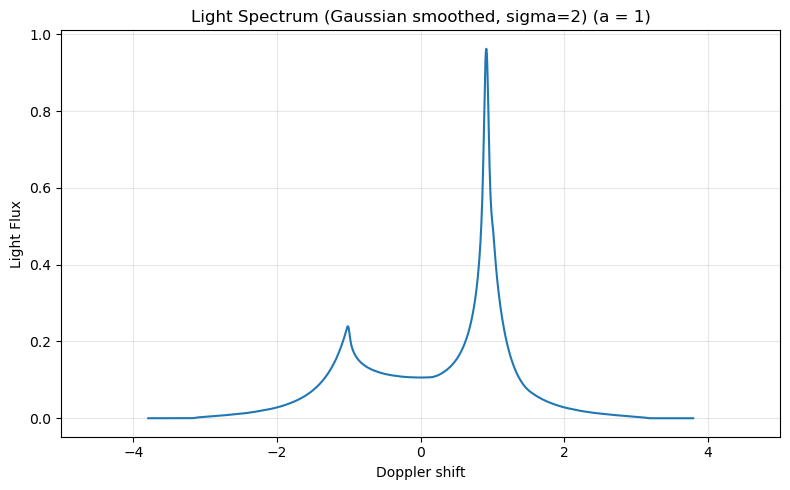

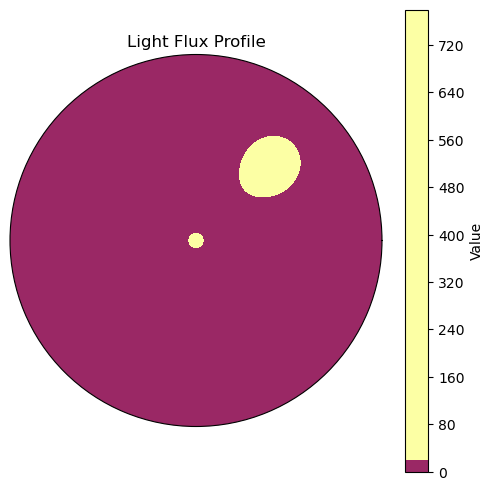

In [ ]:
spots_params = [
    24.8,           # spot_1_max
    0.6,            # spot_r_cent_1
    4 * np.pi/16,   # spot_theta_1
    0.014,           # spot_rad_1
    1.5,            # beta_1
    0.0,            # spot_2_max
    0.6,            # spot_r_cent_2
    -7 * np.pi/16,  # spot_theta_2
    0.03,           # spot_rad_2
    0.5             # beta_2
]
r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids( #TODO: fix
    inv_power_2_spots, radial_spacing="linear",
    other_intens_params= spots_params
)

fname = plot_spectrum_list(
    a_vals=1, intens_funcs=inv_power_2_spots,
    other_intens_params=spots_params, sigma=2, save_info=False
)

plot_polar_profile(r_vals, theta_vals, intens_vals, save_info=False, fname=fname)

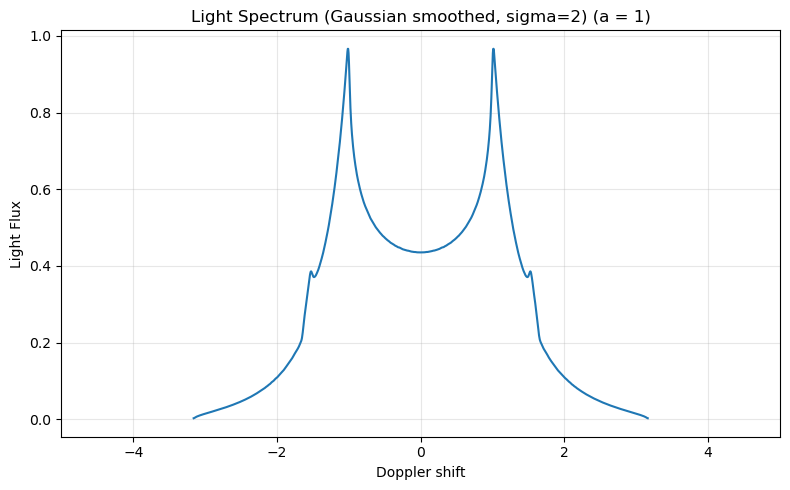

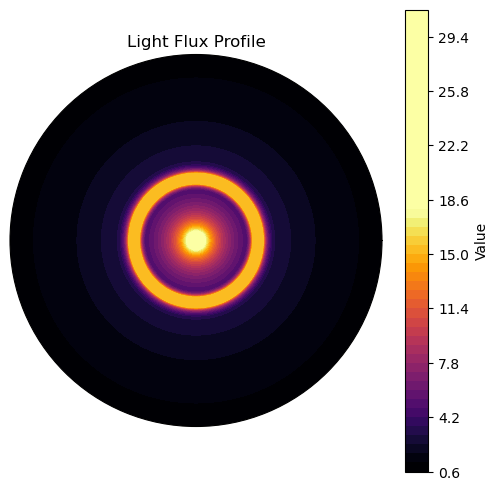

In [ ]:
ring_params = [
    0.5,            # ring_max
    0.4,            # ring_r
    0.05,           # ring_width
    1.5             # beta
]
r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(
    inv_power_1_ring, radial_spacing="linear",
    other_intens_params= ring_params
)


fname = plot_spectrum_list(
    a_vals=1, intens_funcs=inv_power_1_ring,
    other_intens_params=ring_params, sigma=2,
    save_info=False
)

plot_polar_profile(
    r_vals, theta_vals, intens_vals,
    save_info=False, fname = fname
)